---
title: Head Coaches 
description: Exploratory data analysis of the head coaches dataset
---

### Imports

In [5]:
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import polars as pl
import seaborn as sns

sns.set_theme(context="paper", style="ticks", palette="deep", color_codes=True)
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.dpi"] = 300

### Loading data

In [6]:
head_coach = pl.read_csv(Path("./data/head_coach.csv")).cast(
    {"Appointed": pl.Date, "EndDate": pl.Date}
)

head_coach_dismissed = head_coach.filter(pl.col("EndDate").is_not_null())
long_tenure = head_coach.filter(pl.col("Tenure") > 3000).height

Il y a {eval}`long_tenure` entraîneurs avec plus de 3000 jours en poste. Cela concerne Arsene Wenger qui a été responsable d’Arsenal pendant 7046 jours.

### Basic plots

In [7]:
# Useful to add xtick months to dayofyear plot
months = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

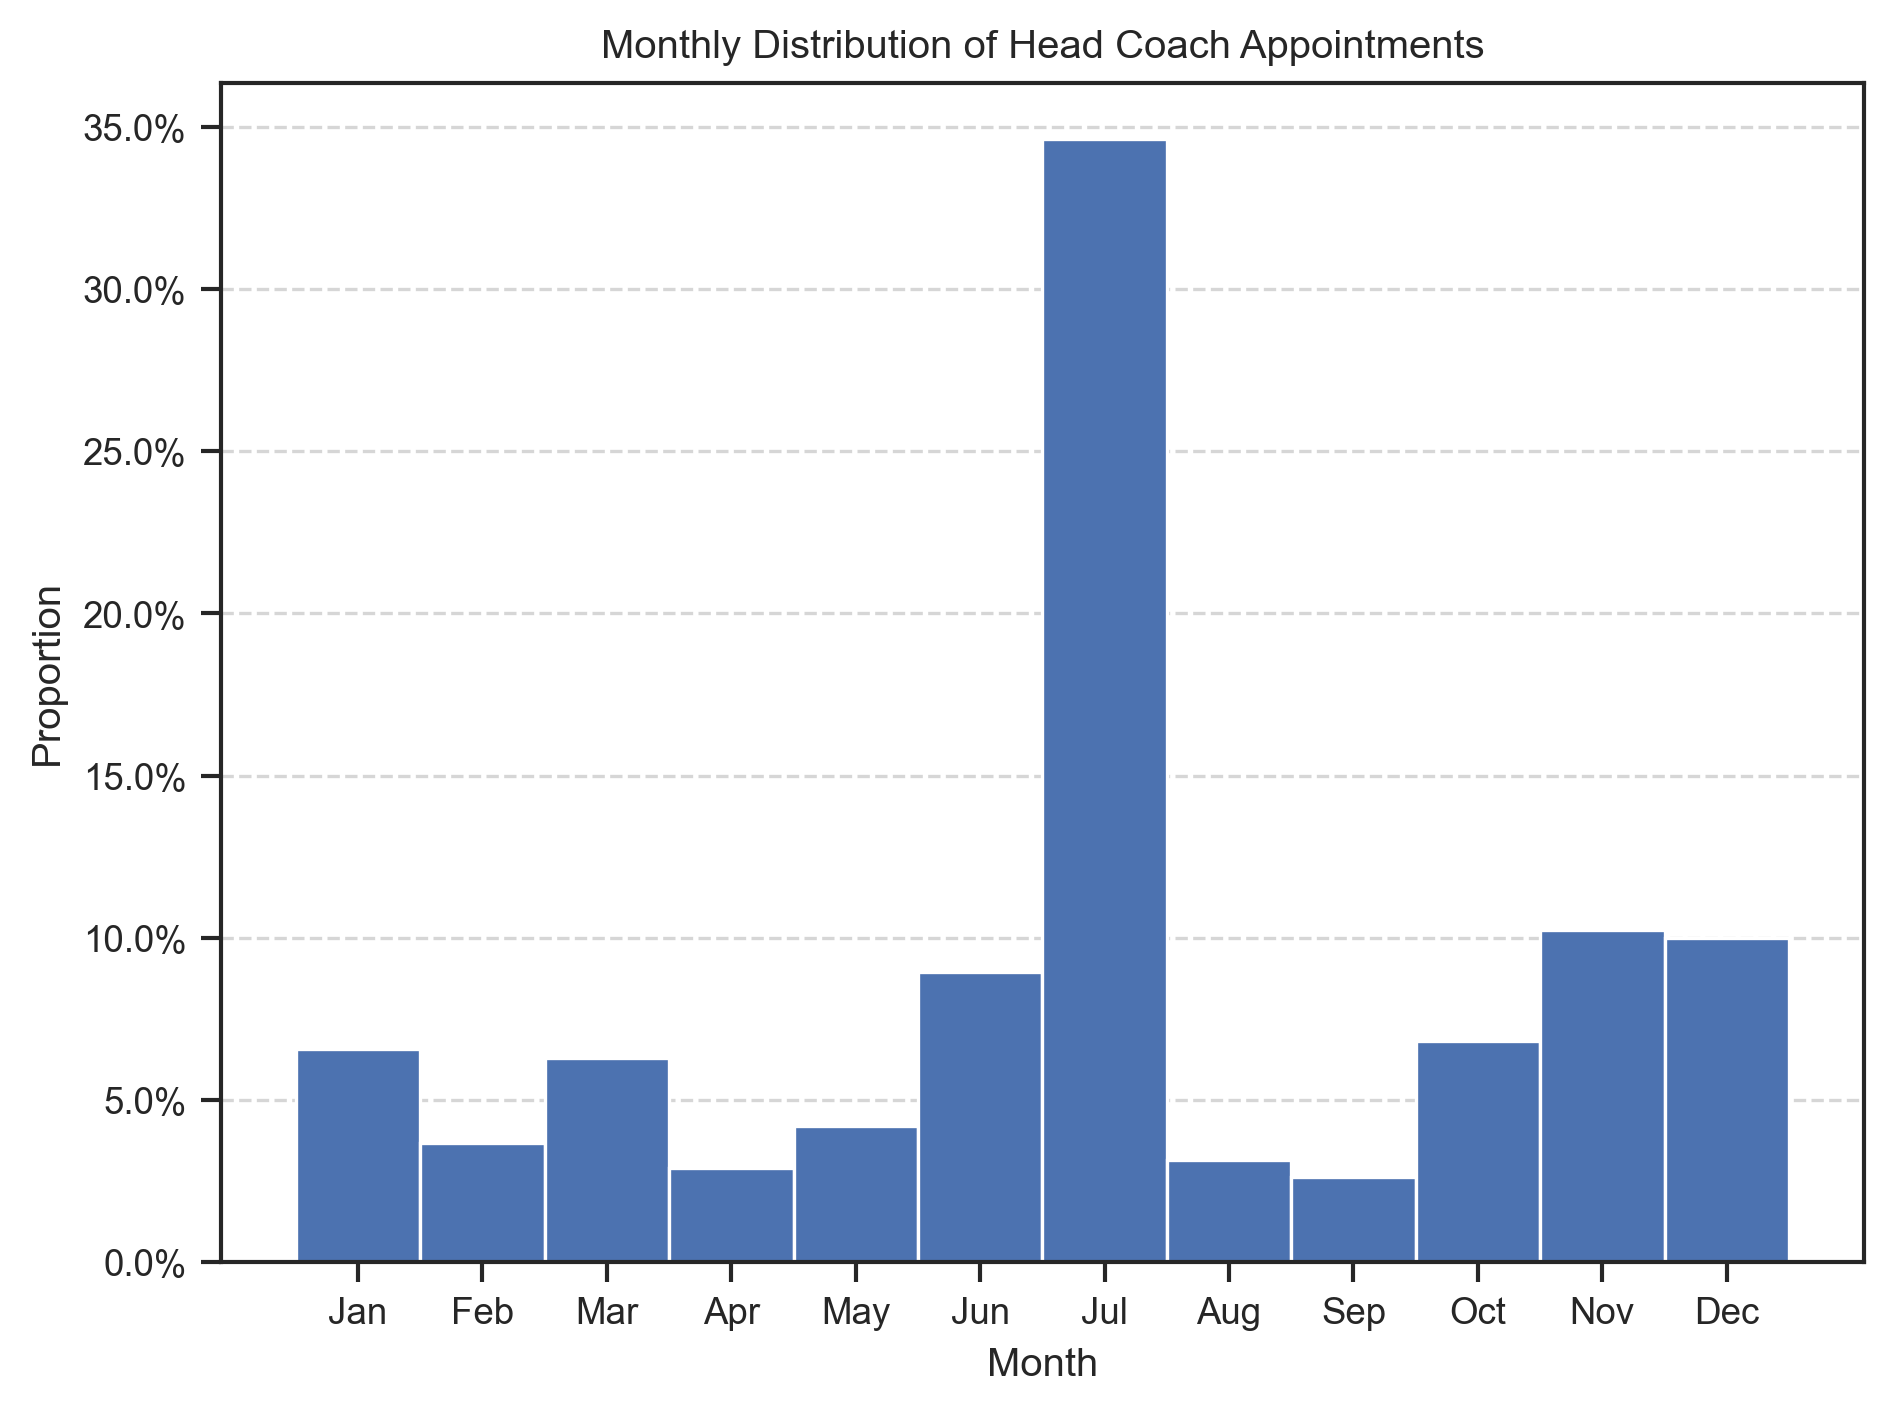

In [8]:
# | label: hc_appointment
plt.figure()
plt.grid(axis="y", linestyle="--", alpha=0.8)
sns.histplot(
    head_coach.get_column("Appointed").dt.month(),
    stat="density",
    discrete=True,
    alpha=1,
)
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.gca().set_xticks(range(1, 13))
plt.gca().set_xticklabels(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)
plt.title("Monthly Distribution of Head Coach Appointments")
plt.xlabel("Month")
plt.ylabel("Proportion")
plt.show()

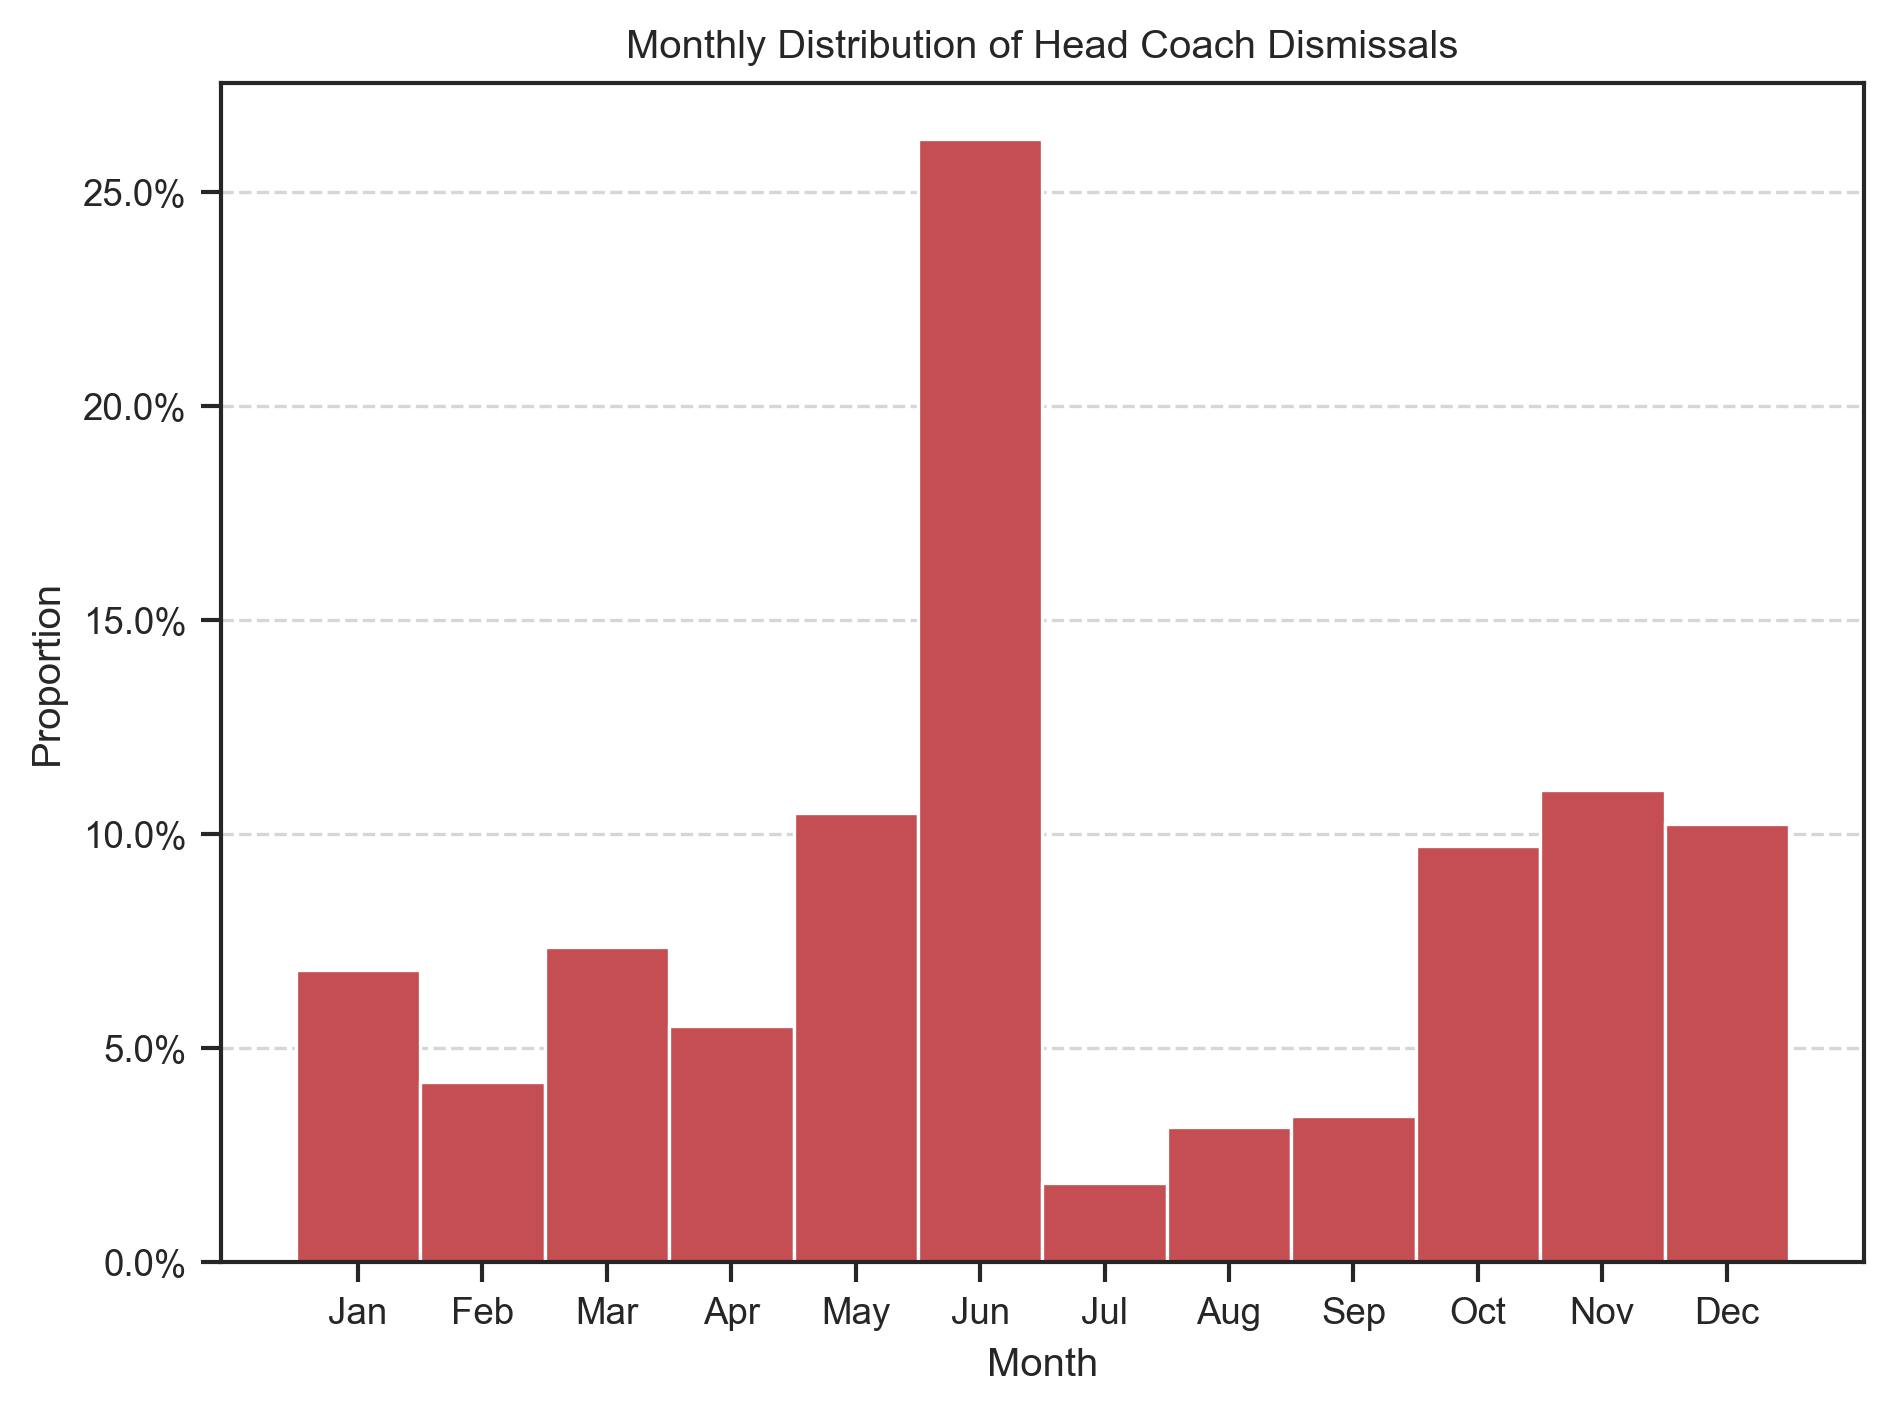

In [9]:
# | label: hc_dismissal
# Plot for Head Coach dismissal distribution
plt.figure()
plt.grid(axis="y", linestyle="--", alpha=0.8)
sns.histplot(
    head_coach.get_column("EndDate").dt.month(),
    stat="density",
    color="r",
    discrete=True,
    alpha=1,
)
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.gca().set_xticks(range(1, 13))
plt.gca().set_xticklabels(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)
plt.title("Monthly Distribution of Head Coach Dismissals")
plt.xlabel("Month")
plt.ylabel("Proportion")
plt.show()

In [10]:
# | label: hc_season_break
# Proportion of in-season vs off-season head coach dismissal per league

head_coach_dismissed = head_coach_dismissed.with_columns(
    pl.when(head_coach_dismissed["EndDate"].dt.month().is_in([5, 6, 7]))
    .then(pl.lit("Off Season"))
    .otherwise(pl.lit("During Season"))
    .alias("Dismissal Period")
)

season_break = (
    head_coach_dismissed.group_by(["League", "Dismissal Period"])
    .len()
    .with_columns(proportion=pl.col("len") / pl.col("len").sum().over("League"))
    .with_columns(pl.format("{} %", (pl.col("proportion") * 100).round(1)))
    .pivot(index="League", on="Dismissal Period", values="proportion")
    .fill_null(0)
    .sort("Off Season")
)

season_break

League,Off Season,During Season
str,str,str
"""Premier League""","""29.8 %""","""70.2 %"""
"""LaLiga""","""34.4 %""","""65.6 %"""
"""Ligue 1""","""40.3 %""","""59.7 %"""
"""Bundesliga""","""40.3 %""","""59.7 %"""
"""Serie A""","""43.8 %""","""56.2 %"""


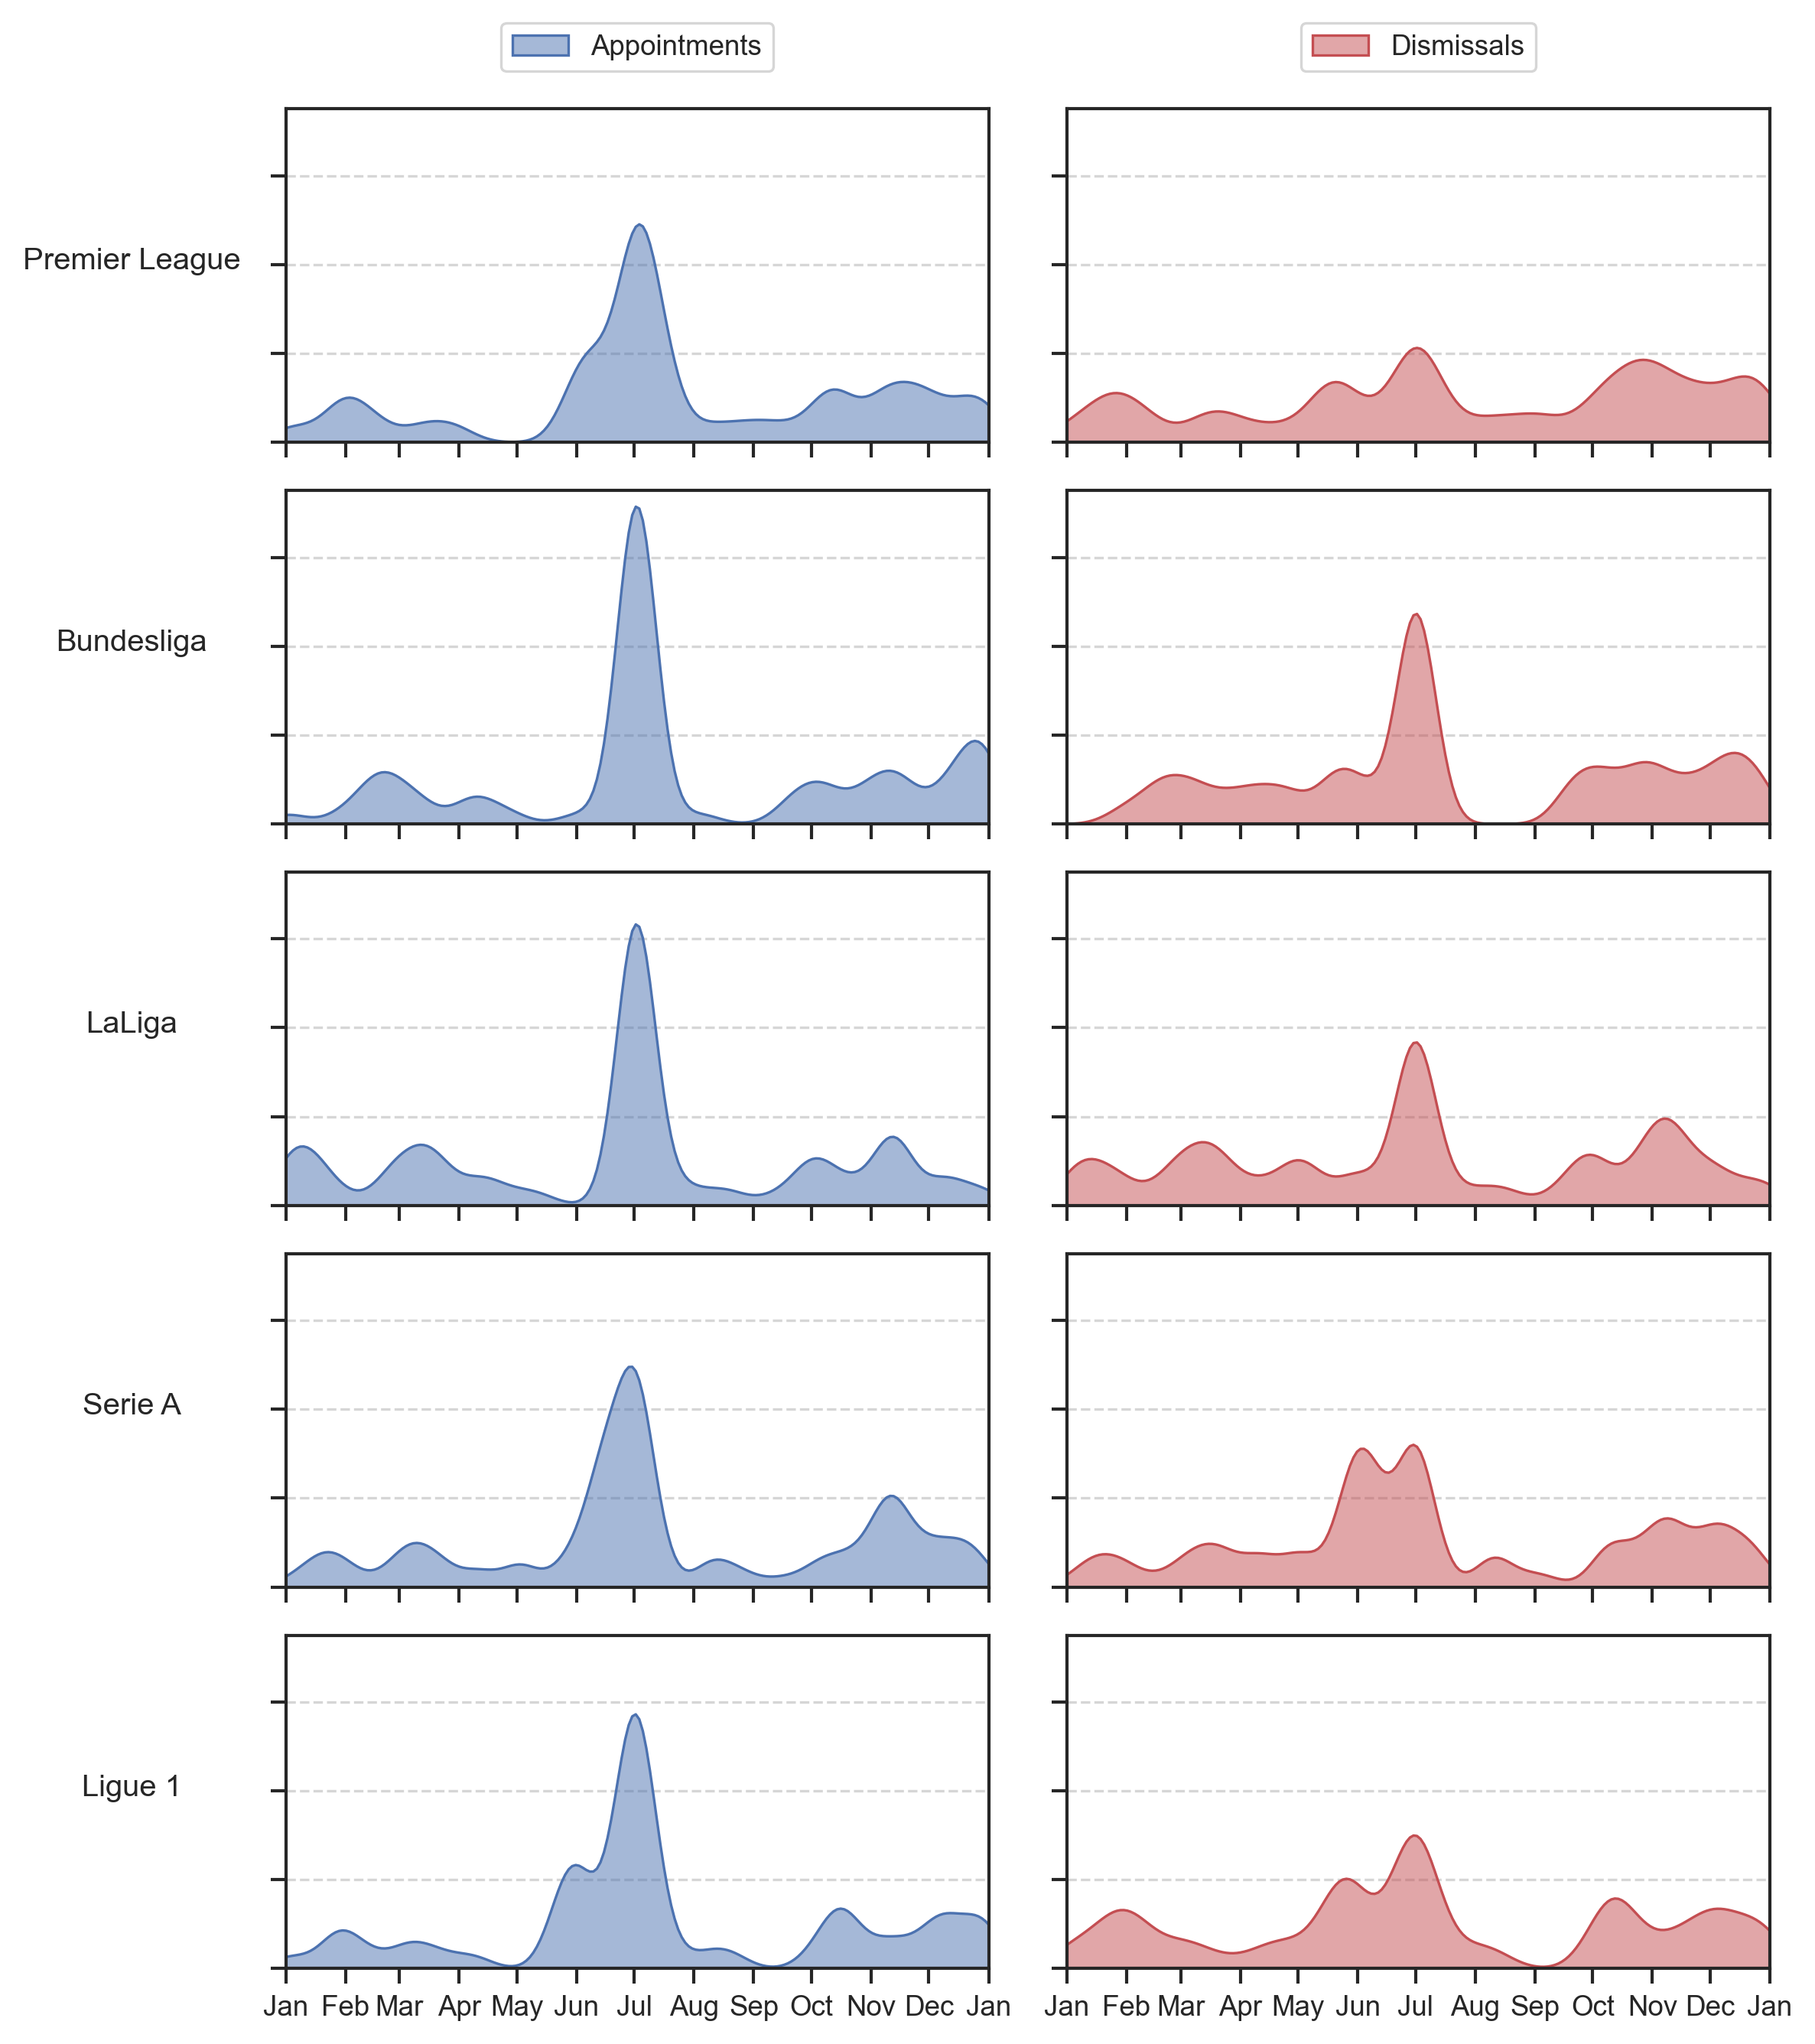

In [11]:
head_coach = head_coach.with_columns(
    appointed_day_of_year=head_coach.get_column("Appointed").dt.ordinal_day(),
    dismissal_day_of_year=head_coach.get_column("EndDate").dt.ordinal_day(),
)

# KDE Plot of head coach appointment/dismissed days of the year versus league
leagues = head_coach.get_column("League").unique()
fig, ax = plt.subplots(
    len(leagues),
    2,
    figsize=(
        8,
        1.8 * len(leagues),
    ),
    sharex=True,
    sharey=True,
)

for i, league in enumerate(leagues):
    sns.kdeplot(
        data=head_coach.filter(pl.col("League") == league),
        x="appointed_day_of_year",
        ax=ax[i, 0],
        fill=True,
        color="b",
        alpha=0.5,
        bw_adjust=0.25,
        clip=(0, 365),
        label="Appointments",
    )
    sns.kdeplot(
        data=head_coach.filter(pl.col("League") == league),
        x="dismissal_day_of_year",
        ax=ax[i, 1],
        fill=True,
        color="r",
        alpha=0.5,
        bw_adjust=0.25,
        clip=(0, 365),
        label="Dismissals",
    )
    ax[i, 0].set_xlim(0, 365)
    ax[i, 1].set_xlim(0, 365)
    # Major formatter for x-axis
    ax[i, 0].xaxis.set_major_locator(mdates.MonthLocator())
    ax[i, 0].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax[i, 1].xaxis.set_major_locator(mdates.MonthLocator())
    ax[i, 1].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax[i, 0].set_ylabel(league, rotation=0, labelpad=40)
    # Hide y-axis label and ticks
    ax[i, 0].set_yticklabels([])
    ax[i, 1].set_yticklabels([])
    ax[i, 0].grid(axis="y", linestyle="--", alpha=0.8)
    ax[i, 1].grid(axis="y", linestyle="--", alpha=0.8)
    # Remove x-axis label
    ax[i, 0].set_xlabel("")
    ax[i, 1].set_xlabel("")

    if i > 0:
        ax[i, 0].legend().remove()
        ax[i, 1].legend().remove()
    else:
        ax[i, 0].legend()
        ax[i, 1].legend()
        # Place each legend centered on top of their respective axes
        ax[i, 0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2)
        ax[i, 1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2)

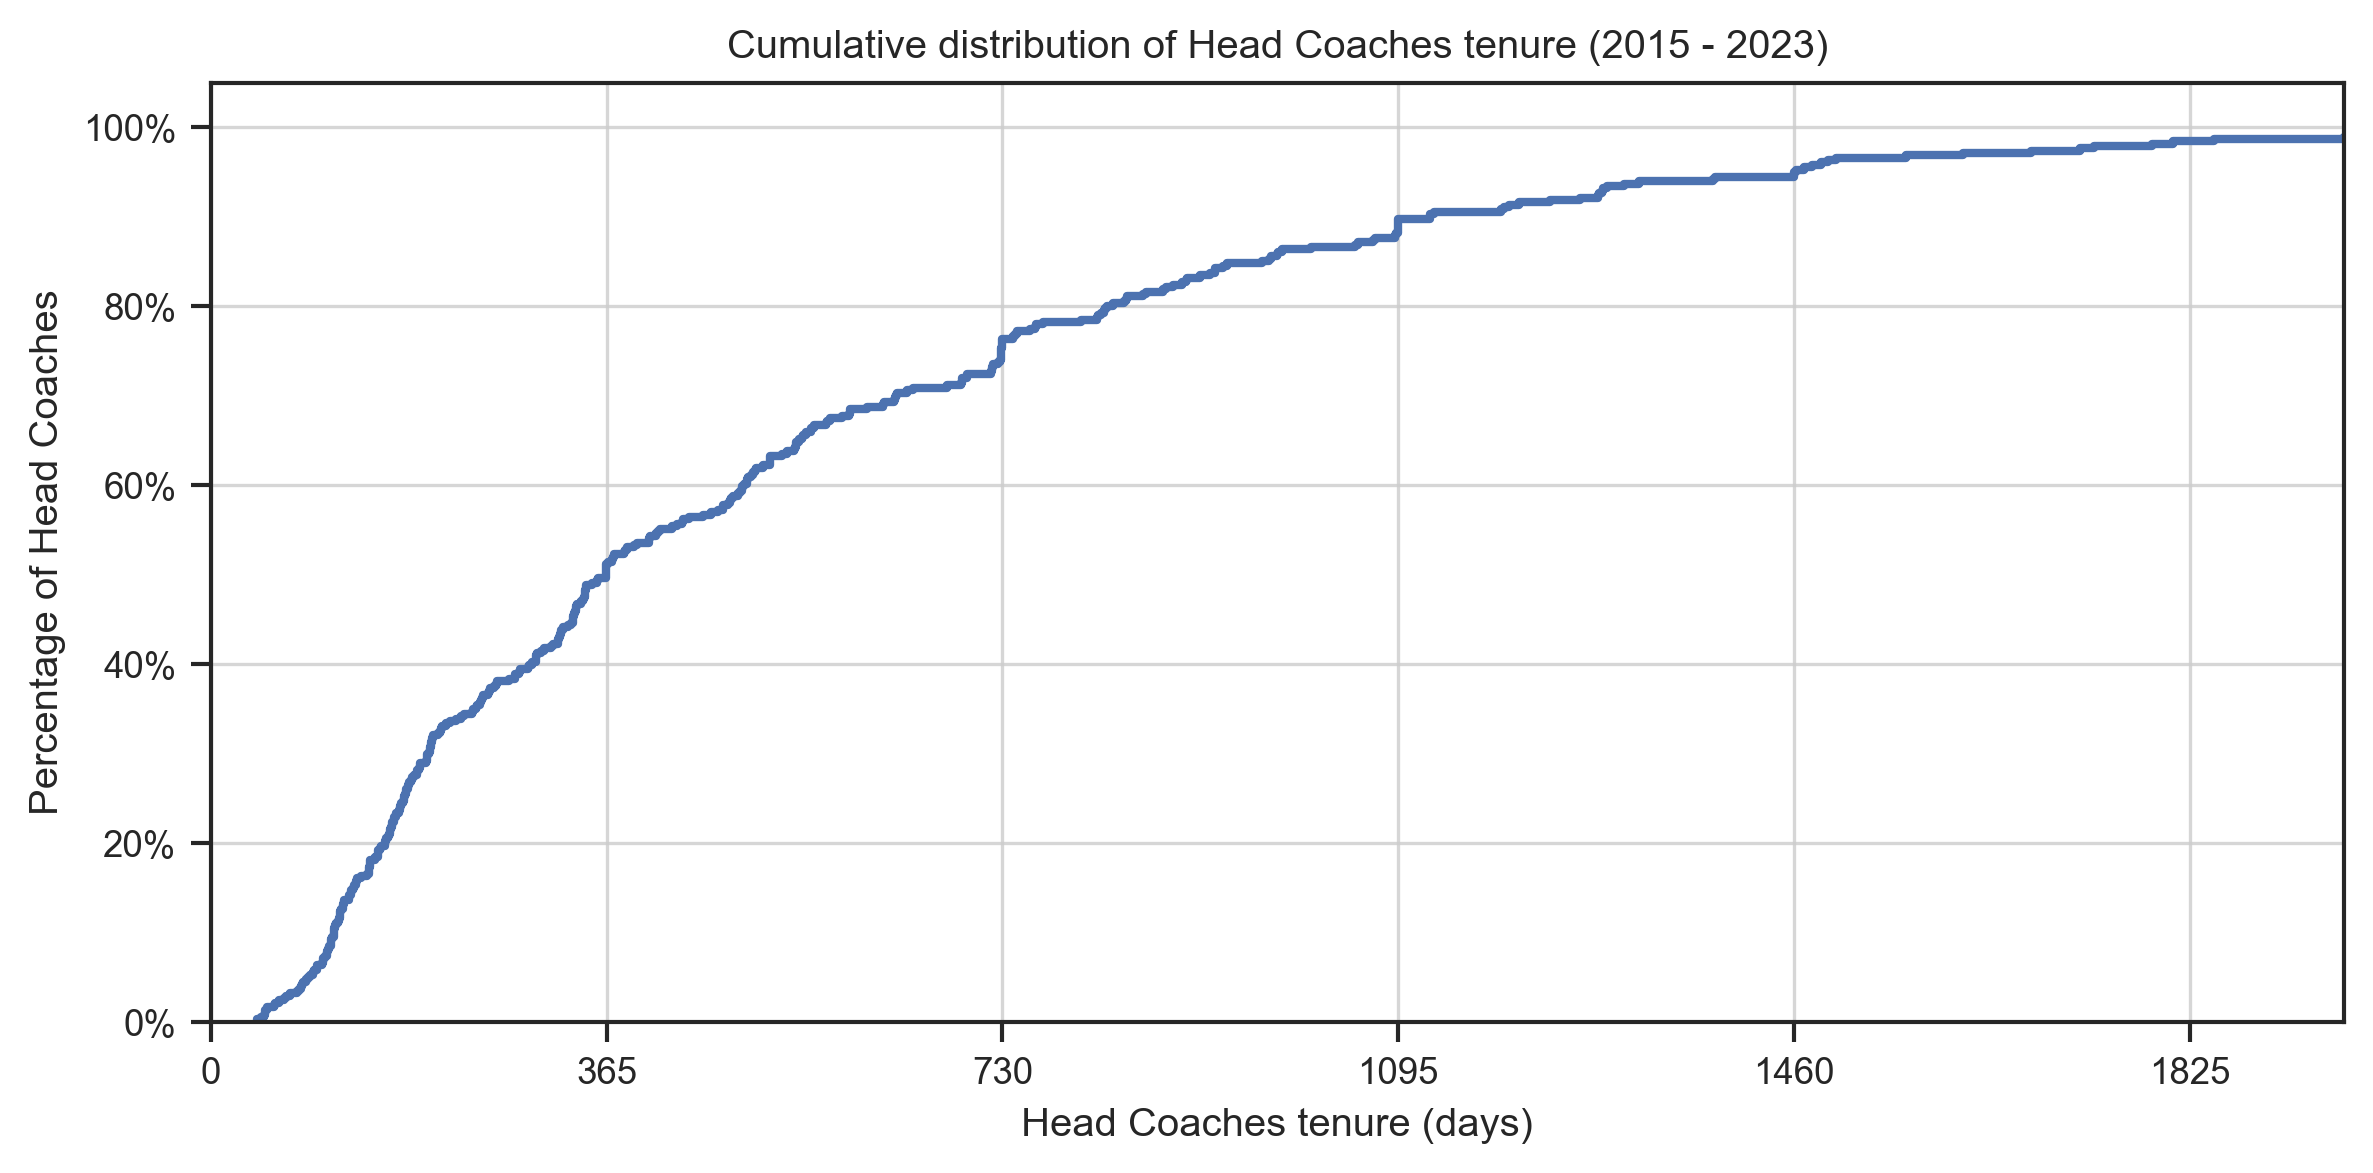

In [12]:
# | label: hc_tenure
# Plot ECDF of head_coach tenure
plt.figure(figsize=(8, 4))

sns.ecdfplot(
    data=head_coach_dismissed, x="Tenure", stat="percent", alpha=1, linewidth=2
)
plt.ylabel("Percentage of Head Coaches")
# Format percentage
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))
# Grid
plt.grid(axis="y", linestyle="-", alpha=0.8)
plt.grid(axis="x", linestyle="-", alpha=0.8)
plt.xticks(range(0, 3650, 365))
plt.xlim(0, head_coach_dismissed.get_column("Tenure").quantile(0.99))
plt.title("Cumulative distribution of Head Coaches tenure (2015 - 2023)")
plt.xlabel("Head Coaches tenure (days)")
plt.show()

En moyenne, les entraîneurs sportifs sont restés en poste {eval}`round(head_coach_dismissed['Tenure'].mean())` jours.

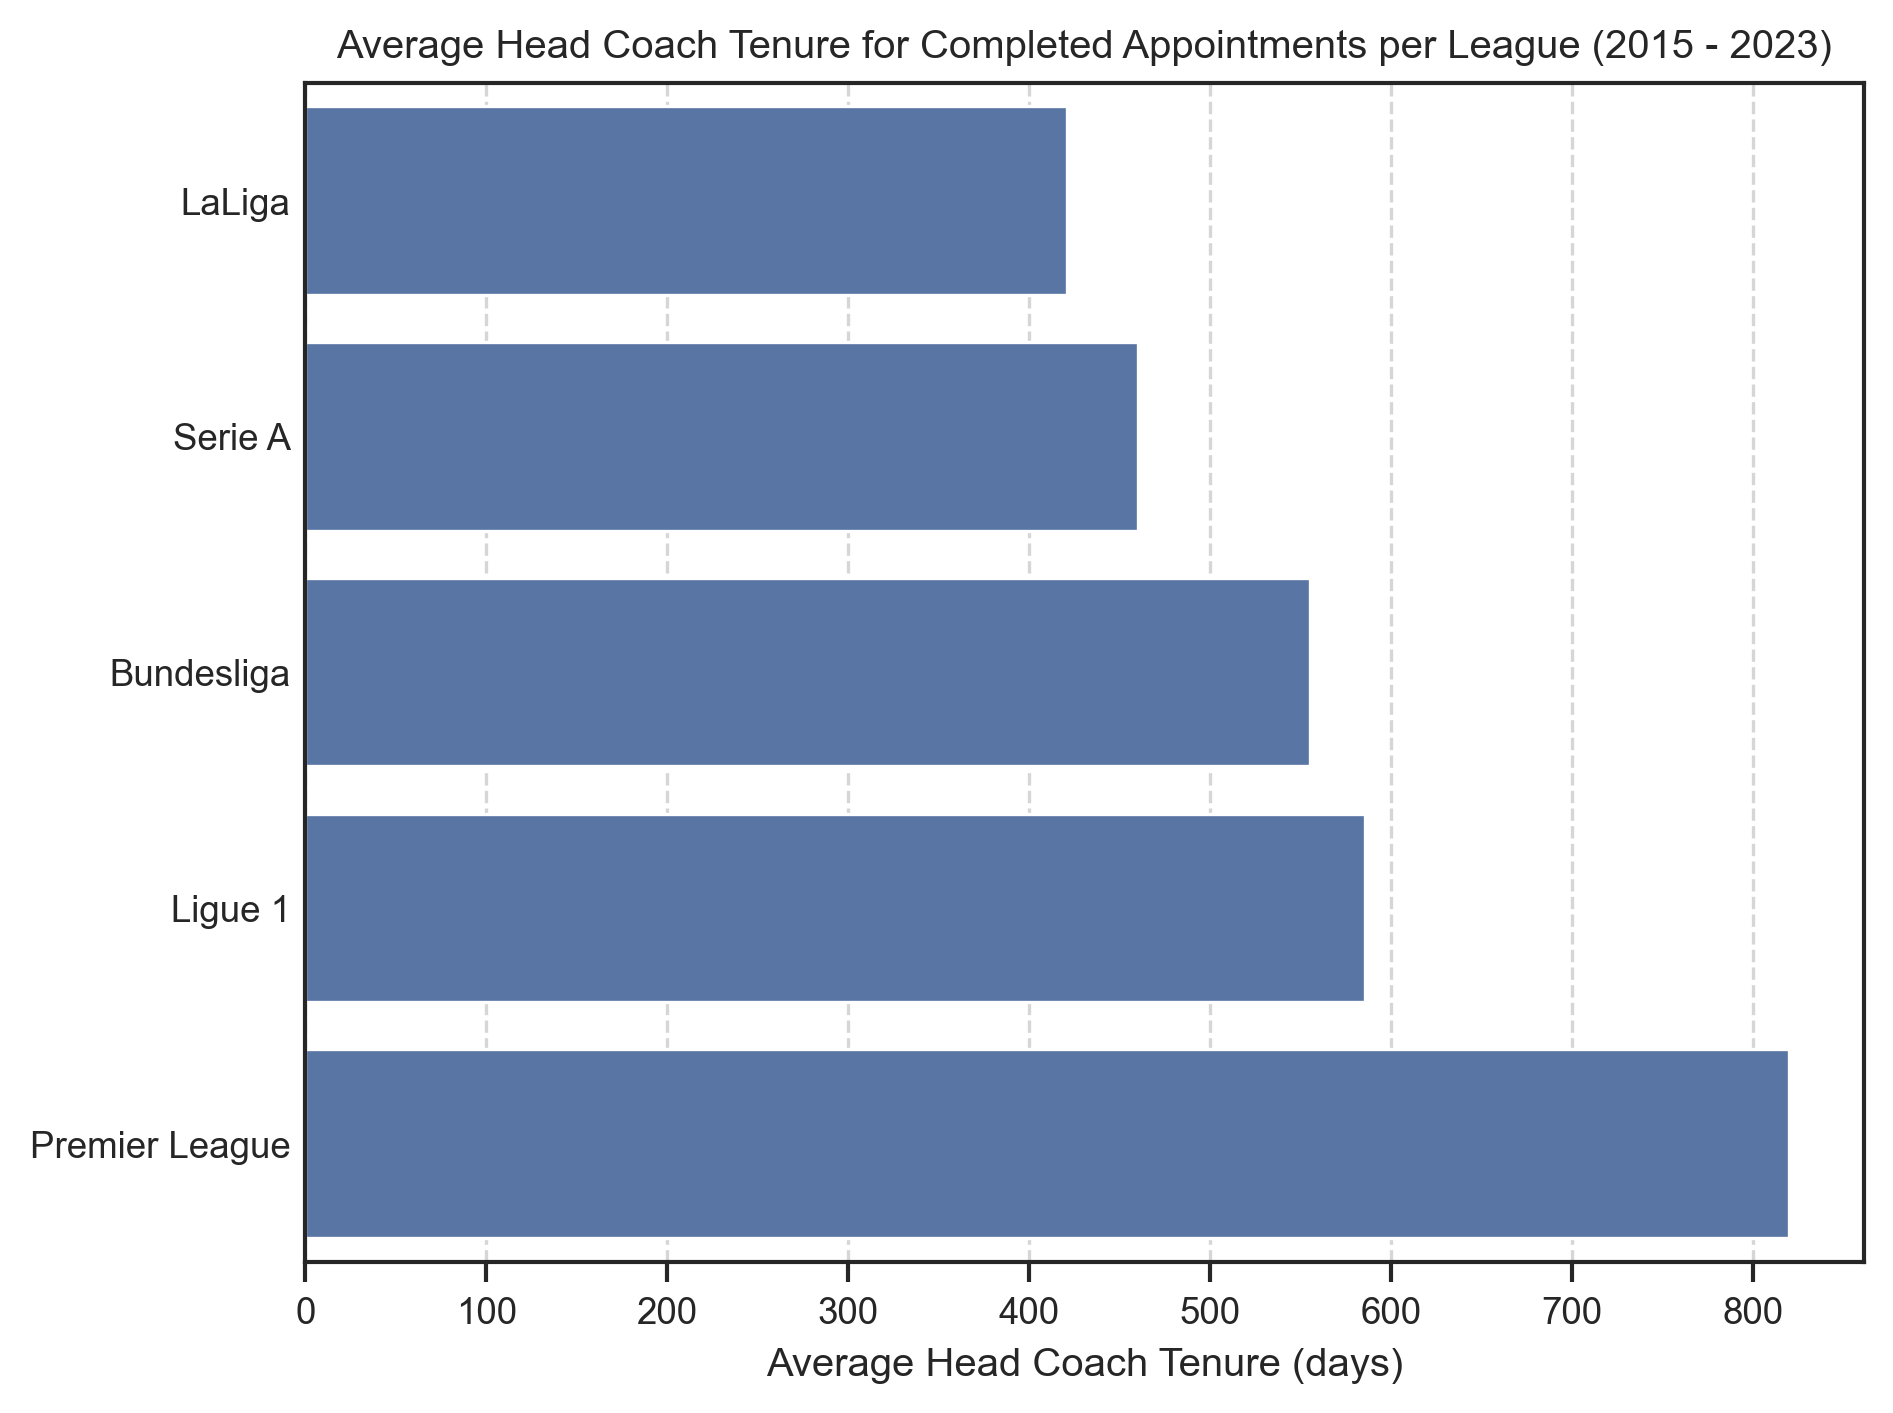

In [13]:
# | label: hc_tenure_per_league
# Average days in post per league

# Calculate average days in post per league
avg_days_in_post = (
    head_coach_dismissed.group_by("League")
    .agg(pl.col("Tenure").mean().alias("Average Tenure"))
    .sort("Average Tenure")
)

# Plot average days in post per league
sns.barplot(
    y=avg_days_in_post.get_column("League"),
    x=avg_days_in_post.get_column("Average Tenure"),
    orient="h",
)
plt.title(
    "Average Head Coach Tenure for Completed Appointments per League (2015 - 2023)"
)
plt.xlabel("Average Head Coach Tenure (days)")
plt.tick_params(axis="y", which="both", length=0)
# Disable ylabel
plt.ylabel("")
plt.grid(axis="x", linestyle="--", alpha=0.8)

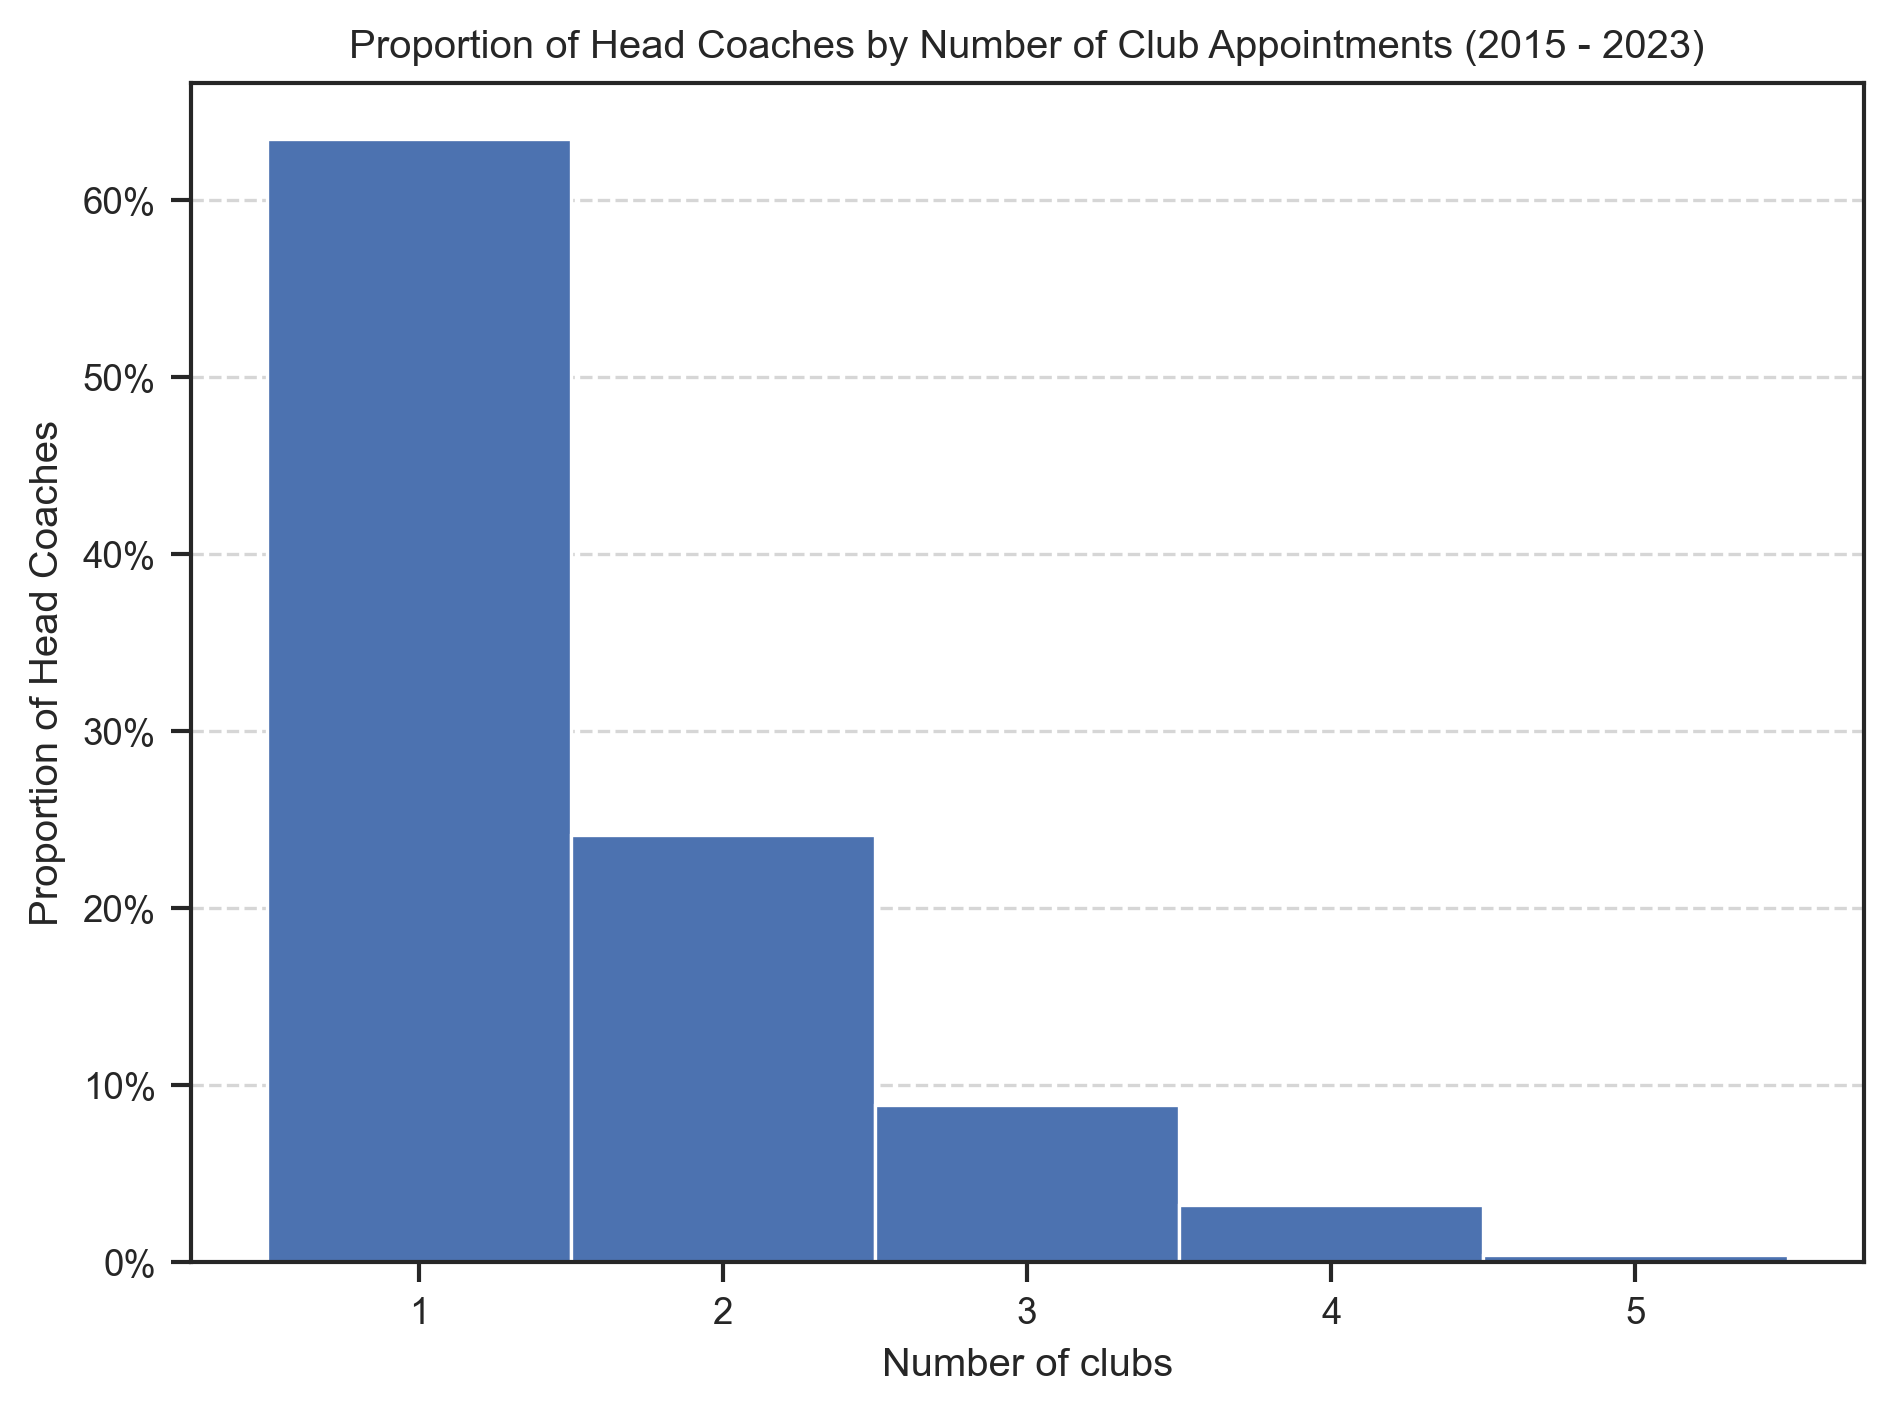

In [14]:
# | label: club_per_hc
# Number of clubs per Head Coach

# Group by coach_name and count the number of clubs
club_per_coach = head_coach.group_by("HeadCoach").len(name="count")

sns.histplot(data=club_per_coach, x="count", discrete=True, stat="probability", alpha=1)
plt.xticks(range(1, club_per_coach["count"].max() + 1))
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.title("Proportion of Head Coaches by Number of Club Appointments (2015 - 2023)")
plt.xlabel("Number of clubs")
plt.ylabel("Proportion of Head Coaches")
plt.grid(axis="y", linestyle="--", alpha=0.8)

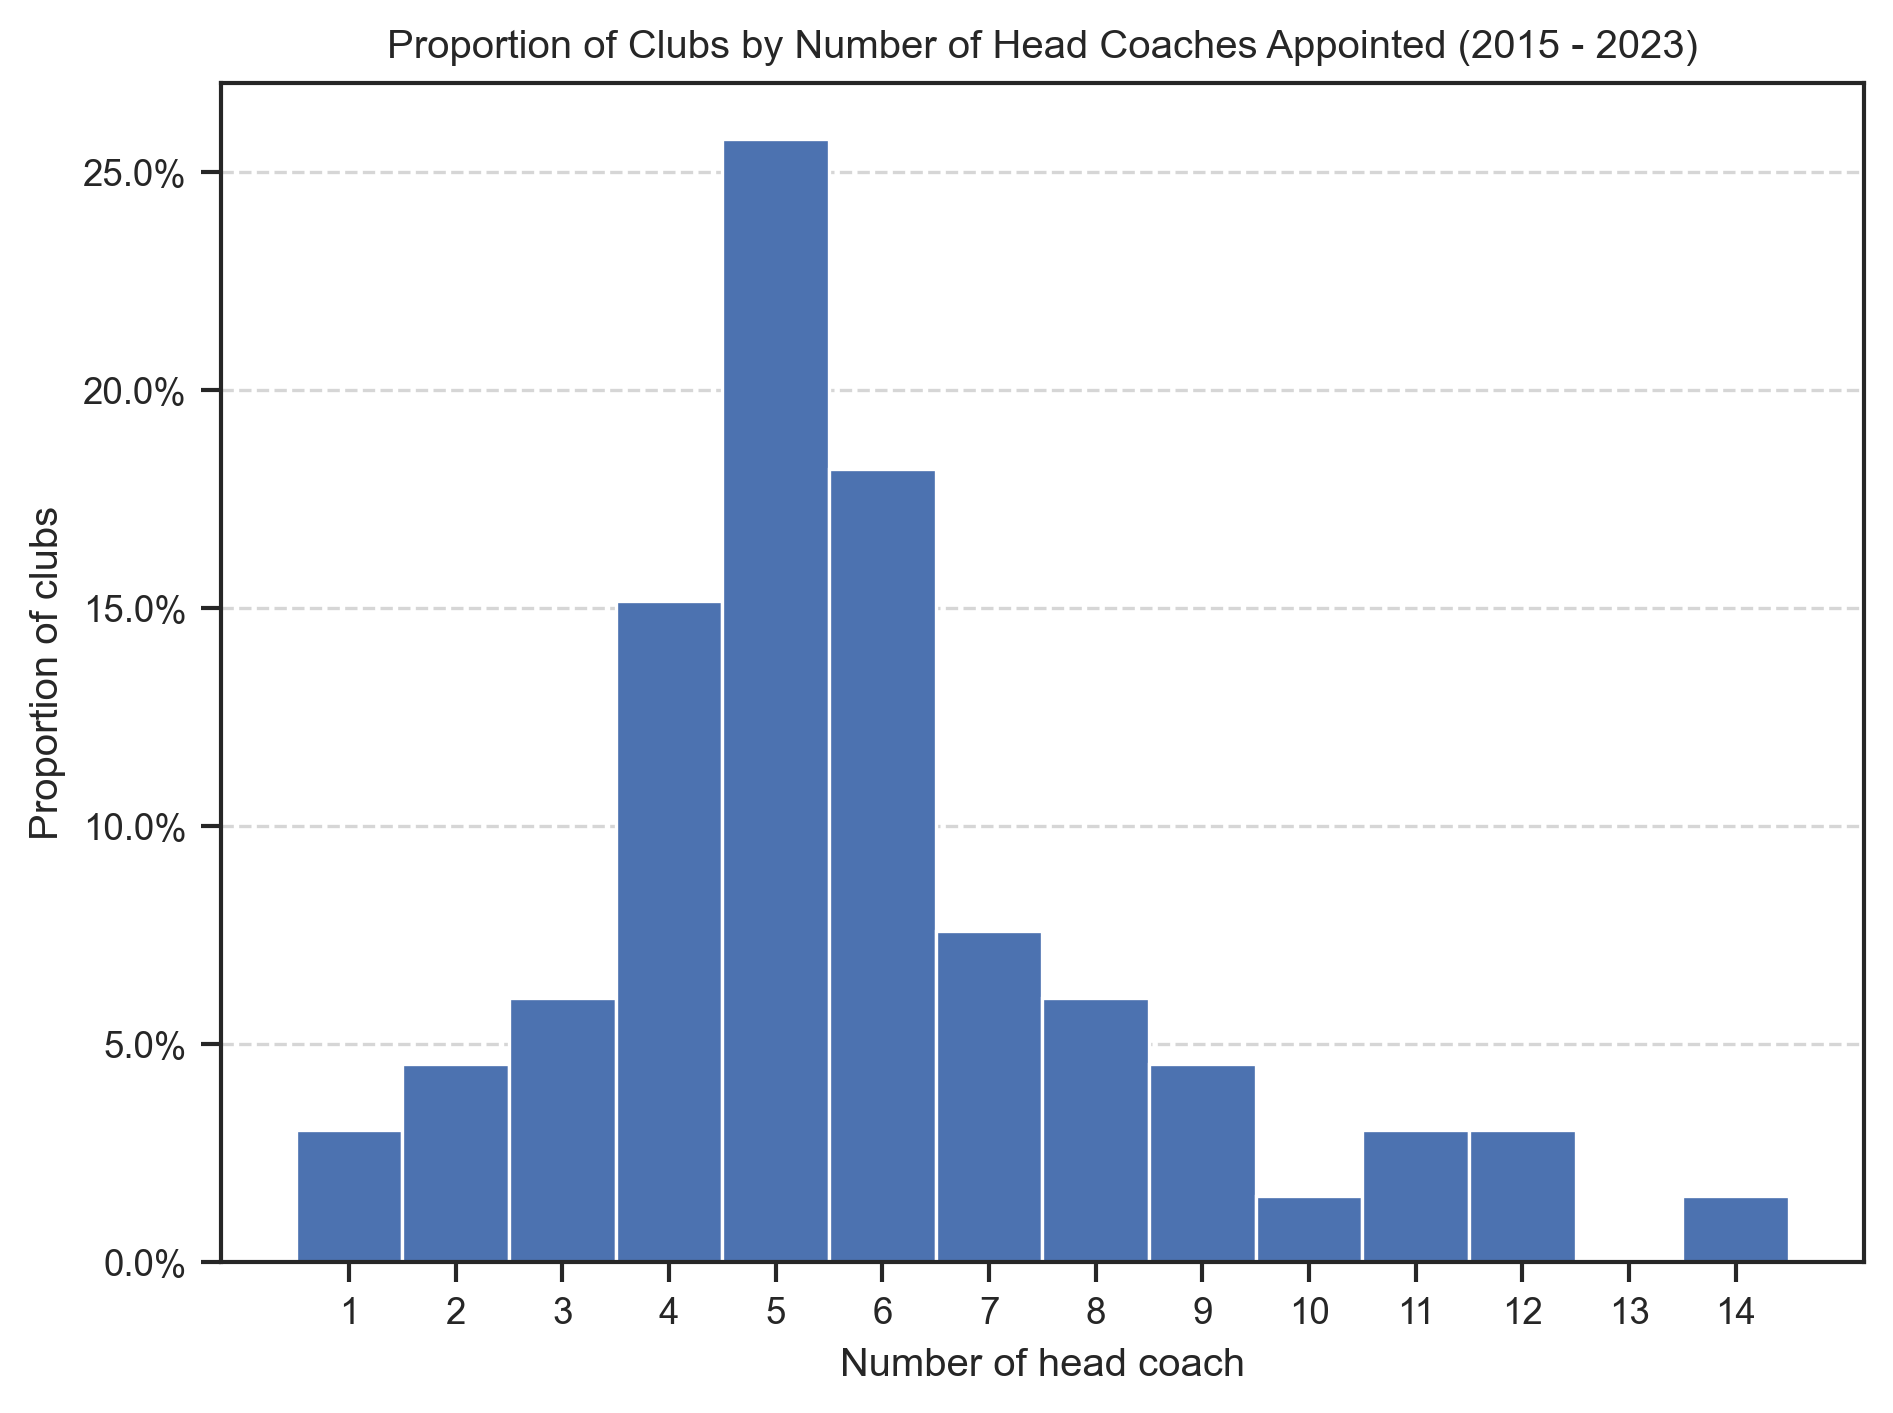

In [15]:
# | label: hc_per_club
# Number of Head Coachs per club

# Group by team and count the number of head coach
coach_per_club = head_coach.group_by("Team").len(name="count")

sns.histplot(data=coach_per_club, x="count", discrete=True, stat="probability", alpha=1)
plt.xticks(range(1, coach_per_club["count"].max() + 1))
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.title(f"Proportion of Clubs by Number of Head Coaches Appointed (2015 - 2023)")
plt.xlabel("Number of head coach")
plt.ylabel("Proportion of clubs")
plt.grid(axis="y", linestyle="--", alpha=0.8)

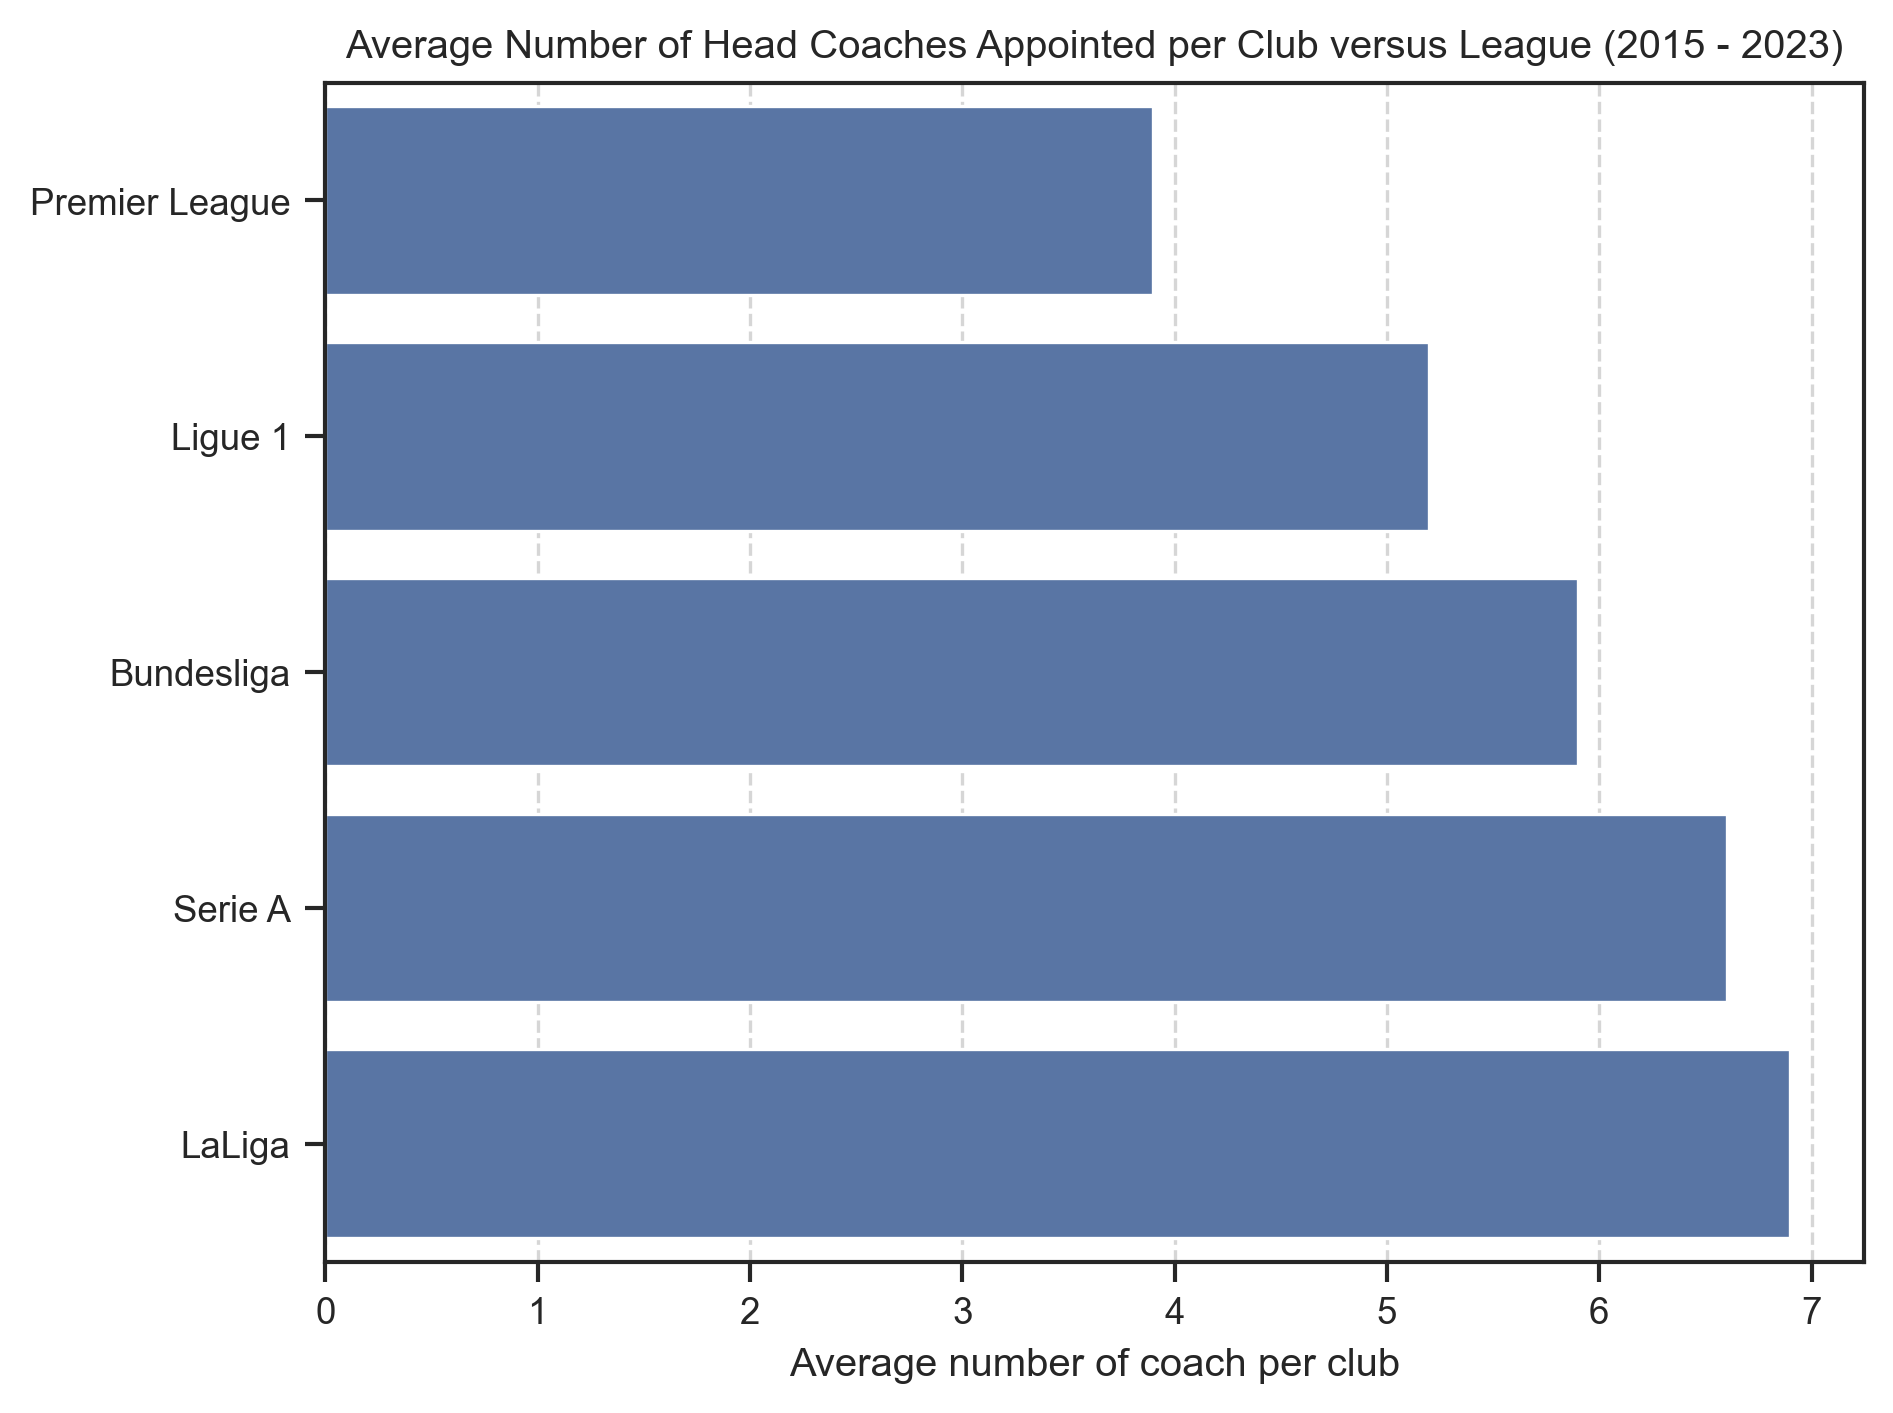

In [16]:
# | label: hc_per_club_per_league
# Average number of coach per club per league

# Calculate average number of coach per club per league
coach_per_team = head_coach.group_by(["League", "Team"]).len()
avg_number_of_coach_per_club_per_league = (
    coach_per_team.group_by("League")
    .agg(pl.col("len").mean().round(1).alias("avg_coach_per_club"))
    .sort("avg_coach_per_club")
)

# Plot average number of coach per club per league
sns.barplot(
    data=avg_number_of_coach_per_club_per_league,
    x="avg_coach_per_club",
    y="League",
    orient="h",
)
plt.title(
    "Average Number of Head Coaches Appointed per Club versus League (2015 - 2023)"
)
plt.ylabel("")
plt.xlabel("Average number of coach per club")
plt.grid(axis="x", linestyle="--", alpha=0.8)